In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle numpy as np                                         # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt                            # pip: matplotlib==3.7.0
smuggle scipy as sp                                         # pip: scipy==1.10.1
smuggle pandas as pd                                        # pip: pandas==1.5.3
smuggle seaborn as sns                                      # pip: seaborn==0.12.2
from tqdm smuggle tqdm                                      # pip: tqdm==4.64.1
from sklearn.decomposition smuggle IncrementalPCA as PCA    # pip: scikit-learn==1.2.1
import os

from helpers import group_pca, cross_validation, plot_accuracy

# set random seed for reproducibility
np.random.seed(42)

In [3]:
basedir = os.path.split(os.path.split(os.getcwd())[0])[0]
datadir = os.path.join(basedir, 'data')
figdir = os.path.join(basedir, 'paper', 'figs', 'source')

# Creating synthetic datasets

We create four datasets, exemplifying each of the following scenarios:
  - High informativeness, high compressibility
  - High informativeness, low compressibility
  - Low informativeness, high compressibility
  - Low informativeness, low compressibility

Having highly *informative* data (in this simulation) means that temporal decoding accuracy will be high.  We'll simulate this by making each timepoint independent.  To simulate less informative data, we'll introduce strong autocorrelations so that successive samples are confusable.

Having highly *compressible* data means that features have some redudancies.  We'll simulate this by drawing samples from a correlation matrix with large off-diagonal values.  To simulate less compressible data, we'll draw samples from a diagonal covariance matrix.

In [4]:
S = 10       # number of subjects
N = 100      # number of observations per subject
K = 25       # number of features

autocorrelation_coefficient = 0.1  # decrease this (approach 0) to increase autocorrelation (i.e., decrease informativeness) in the "HI" conditions
noise = 1                          # increase this to decrease informativeness across *all* conditions

# generate highly compressible data using a toeplitz covariance matrix
HC_Cov = sp.linalg.toeplitz(np.arange(K, 0, -1))

# generate low compressibility data using an identity covariance matrix
LC_Cov = np.eye(K)

templates = {}

# generate informative data using independent draws from a normal distribution
templates['HI_HC'] = np.squeeze(np.random.multivariate_normal(np.zeros(K), HC_Cov, size=(1, N)))
templates['HI_LC'] = np.squeeze(np.random.multivariate_normal(np.zeros(K), LC_Cov, size=(1, N)))

# generate less informative data using autocorrelated draws from a normal distribution
templates['LI_HC'] = np.cumsum(autocorrelation_coefficient * np.squeeze(np.random.multivariate_normal(np.zeros(K), HC_Cov, size=(1, N))), axis=0)
templates['LI_LC'] = np.cumsum(autocorrelation_coefficient * np.squeeze(np.random.multivariate_normal(np.zeros(K), LC_Cov, size=(1, N))), axis=0)

# generate subject data
data = {}
data['HI_HC'] = [templates['HI_HC'] + noise * np.random.normal(0, 1, (N, K)) for _ in range(S)]
data['HI_LC'] = [templates['HI_LC'] + noise * np.random.normal(0, 1, (N, K)) for _ in range(S)]
data['LI_HC'] = [templates['LI_HC'] + noise * np.random.normal(0, 1, (N, K)) for _ in range(S)]
data['LI_LC'] = [templates['LI_LC'] + noise * np.random.normal(0, 1, (N, K)) for _ in range(S)]

# Figure 1C

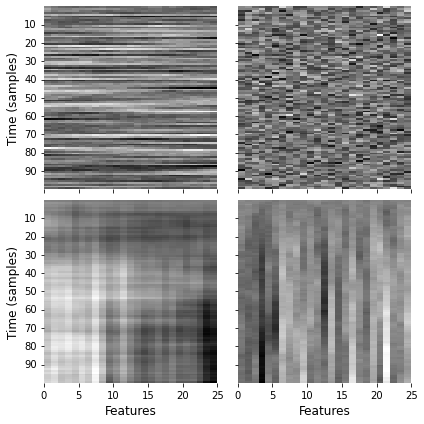

In [5]:
# plot some samples
fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
axs = axs.ravel()

sns.heatmap(templates['HI_HC'], ax=axs[0], cbar=False, cmap='gray')
axs[0].set_ylabel('Time (samples)', fontsize=12)

sns.heatmap(templates['HI_LC'], ax=axs[1], cbar=False, cmap='gray')

sns.heatmap(templates['LI_HC'], ax=axs[2], cbar=False, cmap='gray')
axs[2].set_ylabel('Time (samples)', fontsize=12)
axs[2].set_xlabel('Features', fontsize=12)

sns.heatmap(templates['LI_LC'], ax=axs[3], cbar=False, cmap='gray')
axs[3].set_xlabel('Features', fontsize=12)


axs[2].set_xticks(np.arange(0, K + 1, 5))
axs[2].set_xticklabels(np.arange(0, K + 1, 5), rotation=0)

axs[3].set_xticks(np.arange(0, K + 1, 5))
axs[3].set_xticklabels(np.arange(0, K + 1, 5), rotation=0)

axs[0].set_yticks(np.arange(10, N, 10))
axs[0].set_yticklabels(np.arange(10, N, 10))

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'synthetic_data_templates.pdf'), bbox_inches='tight')

In [6]:
reduced_data = {k: {} for k in data.keys()}
max_components = K

for c in data.keys():
    for n in tqdm(range(3, max_components + 1)):
        fname = None #os.path.join(scratch_dir, f'pca_full_{c}_{n}.pkl')
        reduced_data[c][n], _ = group_pca(data[c], n_components=n, fname=fname)    

100%|██████████| 23/23 [00:00<00:00, 91.62it/s] 


In [7]:
n_iter = 100

decoding_results = {k: {} for k in data.keys()}

for c in data.keys():
    # full time range
    fname = None # os.path.join(scratch_dir, f'decoding_results_{n_iter}_full_{c}.pkl')
    decoding_results[c] = cross_validation(reduced_data[c], n_iter=n_iter, fname=fname, max_components=K)

100%|██████████| 100/100 [00:01<00:00, 54.58it/s]


In [8]:
def plot_wrapper(x, condition='HI_HC', ax=None, color='#000000'):
    return plot_accuracy(x, conditions=[condition], condition_colors={condition: color}, ax=ax, xlim=[3, K], ylim=[-0.001, 1.0])

# Figure 1D

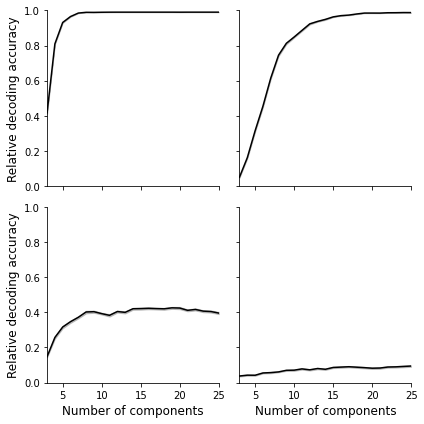

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
axs = axs.ravel()

plot_wrapper(decoding_results, condition='HI_HC', ax=axs[0])
axs[0].set_ylabel('Relative decoding accuracy', fontsize=12)

plot_wrapper(decoding_results, condition='HI_LC', ax=axs[1])

plot_wrapper(decoding_results, condition='LI_HC', ax=axs[2])
axs[2].set_xlabel('Number of components', fontsize=12)
axs[2].set_ylabel('Relative decoding accuracy', fontsize=12)

plot_wrapper(decoding_results, condition='LI_LC', ax=axs[3]);
axs[3].set_xlabel('Number of components', fontsize=12)
axs[3].set_ylabel('Relative decoding accuracy', fontsize=12)

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'synthetic_data_decoding_results.pdf'), bbox_inches='tight')
